# Recommendation System

---

In [1]:
# to auto reload any updated py files
%load_ext autoreload
%autoreload 2

1. Download dataset

In [2]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

--2025-06-03 19:24:38--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  21.0MB/s    in 0.2s    

2025-06-03 19:24:38 (21.0 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [21]:
%%writefile data_loader.py

# load ratings & movie data
import pandas as pd


def load_ratings(path="ml-100k/u.data"):
  '''load file with user ratings'''
  return pd.read_csv(path, sep='\t', header=None,
                     names=["user_id", "movie_id", "rating", "timestamp"])

def load_movies(path='ml-100k/u.item'):
  '''load file with movie metadata'''
  return pd.read_csv(path, sep='|', encoding='latin-1', header=None,
                     names=["movie_id", "title", "release_date", "video_release_date",
                            "IMDb_URL"] + [f"genre_{i}" for i in range(19)])

def build_user_item_matrix(ratings_df):
  ''' pivot to user-item matrix with NaNs for missing values'''
  return ratings_df.pivot_table(index='user_id', columns='movie_id', values='rating')

def fill_missing_zero(matrix):
  '''filling NaNs with 0 for cosine similarity'''
  return matrix.fillna(0)

def center_ratings(matrix):
  '''returning mean centered ratings matrix (for pearson similarity)'''
  user_means = matrix.mean(axis=1)
  return matrix.sub(user_means, axis=0), user_means


Overwriting data_loader.py


In [22]:
#usage reference
from data_loader import load_ratings, load_movies, build_user_item_matrix, fill_missing_zero, center_ratings

ratings = load_ratings()
movies = load_movies()
user_item = build_user_item_matrix(ratings)
user_item_filled = fill_missing_zero(user_item)
user_item_centered, user_means = center_ratings(user_item)

print(ratings.head())
print("=============================================")
print(movies.head())
print("=============================================")
print(user_item_filled.head())
print("=============================================")
print(user_item_centered.head())

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  genre_0  genre_1  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0        0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0        1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0        0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0

In [23]:
# creating similarity.py

%%writefile similarity.py

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(matrix):
  ''' Computing the cosine similarity between users based on rating vectors.
      The input is a matrix with users as rows, movies as columns and no NaNs (filled with zeroes)'''

  similarity = cosine_similarity(matrix.values)
  return pd.DataFrame(similarity, index=matrix.index, columns=matrix.index)

def compute_pearson_similarity(centered_matrix):
    '''Computes the Pearson correlation between users on mean centered data..
       The input is a matrix with mean-centered ratings (NaNs allowed)'''
    return centered_matrix.T.corr(method='pearson')


def get_top_k_neighbors(similarity_matrix, user_id, k=5):
  ''' Get top k most similar users to a given user, excluding themselves.'''
  user_similarities = similarity_matrix.loc[user_id]
  top_k = user_similarities.drop(index=user_id).nlargest(k)
  return top_k


Overwriting similarity.py


In [24]:
# usage reference

from similarity import compute_cosine_similarity, compute_pearson_similarity, get_top_k_neighbors

# user cosine similarity
user_similarity_cosine = compute_cosine_similarity(user_item_filled)

# user pearson similarity
user_similarity_pearson = compute_pearson_similarity(user_item_centered)

# using pearson to get similar users to a certain other user
top_users = get_top_k_neighbors(user_similarity_pearson, user_id=1, k=5)

print(user_similarity_cosine.head())
print("=============================================")
print(user_similarity_pearson.head())
print("=============================================")
print(top_users)

user_id       1         2         3         4         5         6         7    \
user_id                                                                         
1        1.000000  0.166931  0.047460  0.064358  0.378475  0.430239  0.440367   
2        0.166931  1.000000  0.110591  0.178121  0.072979  0.245843  0.107328   
3        0.047460  0.110591  1.000000  0.344151  0.021245  0.072415  0.066137   
4        0.064358  0.178121  0.344151  1.000000  0.031804  0.068044  0.091230   
5        0.378475  0.072979  0.021245  0.031804  1.000000  0.237286  0.373600   

user_id       8         9         10   ...       934       935       936  \
user_id                                ...                                 
1        0.319072  0.078138  0.376544  ...  0.369527  0.119482  0.274876   
2        0.103344  0.161048  0.159862  ...  0.156986  0.307942  0.358789   
3        0.083060  0.061040  0.065151  ...  0.031875  0.042753  0.163829   
4        0.188060  0.101284  0.060859  ...  0.052107

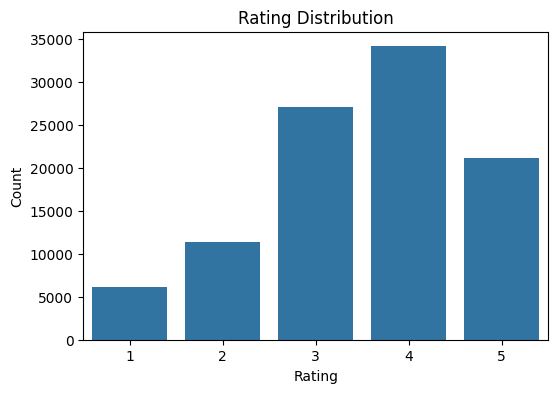

In [ ]:
# rating distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [ ]:
# user-item matrix sparsity
n_users= ratings['user_id'].nunique()
n_movies = ratings['movie_id'].nunique()
sparsity =1.0 - len(ratings) / (n_users * n_movies)

print(f"User-Tem Matrix Sparsity: {sparsity:.4f}")

User-Tem Matrix Sparsity: 0.9370


In [ ]:
# most active users & most rated movies

top_users = ratings['user_id'].value_counts().head()
top_movies = ratings['movie_id'].value_counts().head()

print("Top 5 Active Users:")
print(top_users)

print("\nTop 5 Most Rated Movies:")
top_movies_ids = top_movies.index
print(movies[movies['movie_id'].isin(top_movies_ids)][["movie_id", "title"]])


Top 5 Active Users:
user_id
405    737
655    685
13     636
450    540
276    518
Name: count, dtype: int64

Top 5 Most Rated Movies:
     movie_id                      title
49         50           Star Wars (1977)
99        100               Fargo (1996)
180       181  Return of the Jedi (1983)
257       258             Contact (1997)
293       294           Liar Liar (1997)


In [ ]:
avg_movies_per_user = ratings['user_id'].value_counts().mean()
print(f"Average movies rated per user: {avg_movies_per_user:.2f}")

Average movies rated per user: 106.04


In [ ]:
%%writefile data_loader.py

def hello():
    print("Hello test data loader")


In [ ]:
!cat data_loader.py

In [ ]:
%load_ext autoreload
%autoreload 2
